# VAMOS RacingTuner Test on ZDT1 (2048 experiments)

This notebook exercises the VAMOS tuning stack end-to-end on ZDT1 (30 variables) using a RacingTuner with a 2048-experiment budget. It defines a toy NSGA-II-like runner to produce non-dominated fronts on ZDT1, computes hypervolume as the tuning objective, configures the tuning task, scenario, sampler, and runs the tuning experiment. A simple plot of best-so-far hypervolume is shown at the end.

In [1]:
import random
from typing import Any, Dict, List

import numpy as np
import matplotlib.pyplot as plt

# VAMOS imports (adapt paths if needed)
from vamos.tuning.param_space import ParamSpace, Real, Int, Categorical
from vamos.tuning.tuning_task import TuningTask, Instance, EvalContext
from vamos.tuning.scenario import Scenario
from vamos.tuning.sampler import UniformSampler, ModelBasedSampler
from vamos.tuning.racing import RacingTuner
from vamos.tuning.experiment import TuningExperiment, TunerKind
from vamos.algorithm.variation import VariationPipeline


## ZDT1 helpers: objectives, non-dominated filtering, hypervolume (2D)

ZDT1 (minimization):
- 30 decision variables in [0, 1]
- f1(x) = x0
- g(x) = 1 + 9 * sum_{i=1}^{n-1} x_i / (n-1)
- f2(x) = g * (1 - sqrt(f1 / g))

We provide:
- `zdt1_eval(X)` â†’ objective matrix (N, 2)
- `non_dominated_mask(F)` â†’ boolean mask of non-dominated rows
- `hypervolume_2d(F, ref_point=(1.1,1.1))` â†’ area of dominated region (assumes minimization), with simple normalization.

In [2]:
def zdt1_eval(X: np.ndarray) -> np.ndarray:
    """Evaluate ZDT1 objectives for population X (shape: (N, D)). Minimization."""
    f1 = X[:, 0]
    g = 1.0 + 9.0 * np.sum(X[:, 1:], axis=1) / (X.shape[1] - 1)
    f2 = g * (1.0 - np.sqrt(f1 / g))
    return np.vstack([f1, f2]).T


def non_dominated_mask(F: np.ndarray) -> np.ndarray:
    """Return a boolean mask marking non-dominated points in F (shape: (N, M)). Minimization."""
    N = F.shape[0]
    mask = np.ones(N, dtype=bool)
    for i in range(N):
        if not mask[i]:
            continue
        fi = F[i]
        dominates = np.all(F <= fi, axis=1) & np.any(F < fi, axis=1)
        mask[dominates] = False
    return mask


def hypervolume_2d(F: np.ndarray, ref_point=(1.1, 1.1)) -> float:
    """
    Compute 2D hypervolume for a non-dominated set F (minimization).
    Assumes ref_point dominates all points in F. Simple rectangle slicing.
    """
    if F.size == 0:
        return 0.0
    mask = non_dominated_mask(F)
    nd = F[mask]
    nd = nd[nd[:, 0].argsort()]  # sort by f1 ascending
    hv = 0.0
    rp_f1, rp_f2 = ref_point
    for f1, f2 in nd:
        width = rp_f1 - f1
        height = rp_f2 - f2
        hv += width * height
        rp_f2 = f2  # next slice starts at this f2
    return float(hv)

## Toy NSGA-II-like runner for ZDT1

We implement a lightweight NSGA-II-flavored loop:
- Random initial population in [0,1]^30.
- Variation via simple SBX-like blend and Gaussian-ish mutation controlled by hyperparameters.
- Non-dominated selection + random fill to maintain population size.

Hyperparameters consumed from `config`:
- `population_size` (int)
- `crossover_prob` (float)
- `mutation_prob` (float)
- `sbx_eta` (float) â€” used as a spread parameter for crossover.

In [3]:
def build_variation_pipeline(config: Dict[str, Any], n_vars: int) -> VariationPipeline:
    cross_method = config.get('crossover_type', 'sbx')
    mutation_method = config.get('mutation_type', 'gaussian')
    repair_method = config.get('repair', 'clip')
    cross_prob = float(config.get('crossover_prob', 0.9))
    mutation_prob = float(config.get('mutation_prob', 0.1))
    cross_params = {'prob': cross_prob}
    # crossover-specific params
    if cross_method == 'sbx':
        cross_params['eta'] = float(config.get('sbx_eta', 20.0))
    elif cross_method == 'blx_alpha':
        cross_params['alpha'] = float(config.get('blend_alpha', 0.5))
    elif cross_method == 'pcx':
        cross_params['sigma_eta'] = float(config.get('sigma_eta', 0.1))
        cross_params['sigma_zeta'] = float(config.get('sigma_zeta', 0.1))
    elif cross_method == 'undx':
        cross_params['sigma_xi'] = float(config.get('sigma_xi', 0.5))
        cross_params['sigma_eta'] = float(config.get('sigma_eta', 0.35))
    elif cross_method == 'spx':
        cross_params['epsilon'] = float(config.get('epsilon', 0.5))
    # arithmetic uses only prob

    mut_params = {'prob': mutation_prob}
    if mutation_method in ('pm', 'linked_polynomial'):
        mut_params['eta'] = float(config.get('mutation_eta', 20.0))
    if mutation_method == 'non_uniform':
        mut_params['perturbation'] = float(config.get('perturbation', 0.5))
    if mutation_method == 'gaussian':
        mut_params['sigma'] = float(config.get('gauss_sigma', 0.1))
    if mutation_method == 'cauchy':
        mut_params['gamma'] = float(config.get('gamma', 0.1))
    if mutation_method == 'uniform':
        mut_params['perturb'] = float(config.get('uniform_perturb', 0.1))

    xl = np.zeros(n_vars)
    xu = np.ones(n_vars)
    repair_cfg = None if repair_method in (None, '') else (str(repair_method), {})
    return VariationPipeline(
        encoding='real',
        cross_method=cross_method,
        cross_params=cross_params,
        mut_method=mutation_method,
        mut_params=mut_params,
        xl=xl,
        xu=xu,
        workspace=None,
        repair_cfg=repair_cfg,
        problem=None,
    )


def run_toy_nsga2_zdt1(
    config: Dict[str, Any],
    ctx: EvalContext,
    n_vars: int = 30,
    ref_point=(1.1, 1.1),
) -> float:
    """
    Very simplified NSGA-II-like search on ZDT1 using VariationPipeline.
    Returns normalized hypervolume (higher is better).
    """
    rng = np.random.default_rng(ctx.seed + 12345)  # deterministic per seed
    pop_size = int(config.get('population_size', 100))
    pop_size = max(10, min(pop_size, 512))
    budget = max(100, int(ctx.budget))
    n_generations = max(5, min(50, budget // pop_size))
    pipeline = build_variation_pipeline(config, n_vars)
    parents_per_group = pipeline.parents_per_group
    pop = rng.random((pop_size, n_vars))
    for _ in range(n_generations):
        F = zdt1_eval(pop)
        nd_pop = pop[non_dominated_mask(F)]
        if nd_pop.shape[0] < parents_per_group:
            nd_pop = pop
        parent_count = parents_per_group * max(1, pop_size // parents_per_group)
        parents = nd_pop[rng.integers(0, nd_pop.shape[0], size=parent_count)]
        offspring = pipeline.produce_offspring(parents, rng)
        combined = np.vstack([pop, offspring])
        F_combined = zdt1_eval(combined)
        mask_combined = non_dominated_mask(F_combined)
        nd_combined = combined[mask_combined]
        if nd_combined.shape[0] >= pop_size:
            idx = rng.choice(nd_combined.shape[0], size=pop_size, replace=False)
            pop = nd_combined[idx]
        else:
            remaining = pop_size - nd_combined.shape[0]
            scores = -F_combined.sum(axis=1)
            order = np.argsort(-scores)
            fill = combined[order[:remaining]]
            pop = np.vstack([nd_combined, fill])
    F_final = zdt1_eval(pop)
    mask_final = non_dominated_mask(F_final)
    hv = hypervolume_2d(F_final[mask_final], ref_point=ref_point)
    norm = ref_point[0] * ref_point[1]
    return float(hv / norm)


## Build ParamSpace, instances, and TuningTask for ZDT1

Hyperparameters to tune:
- `population_size`: Int [32, 256]
- `crossover_prob`: Real [0.6, 1.0]
- `mutation_prob`: Real [0.01, 0.5]
- `sbx_eta`: Real [5, 40]

Single instance `"zdt1_30"` with seeds `[1, 2, 3]`.

In [4]:
def build_param_space() -> ParamSpace:
    return ParamSpace(
        params={
            'population_size': Int(32, 256),
            'crossover_prob': Real(0.6, 1.0),
            'mutation_prob': Real(0.01, 0.5),
            'sbx_eta': Real(5.0, 40.0),
            'blend_alpha': Real(0.0, 0.8),
            'sigma_eta': Real(0.01, 0.5),
            'sigma_zeta': Real(0.01, 0.5),
            'sigma_xi': Real(0.01, 1.0),
            'epsilon': Real(0.0, 1.0),
            'mutation_eta': Real(5.0, 40.0),
            'perturbation': Real(0.01, 1.0),
            'gauss_sigma': Real(0.01, 0.3),
            'gamma': Real(0.01, 0.5),
            'uniform_perturb': Real(0.01, 0.5),
            'crossover_type': Categorical(['sbx', 'blx_alpha', 'arithmetic', 'pcx', 'undx', 'spx']),
            'mutation_type': Categorical(['pm', 'non_uniform', 'gaussian', 'uniform_reset', 'cauchy', 'uniform', 'linked_polynomial']),
            'repair': Categorical(['clip', 'reflect', 'resample', 'round']),
        }
    )


def build_zdt1_instances() -> List[Instance]:
    return [Instance(name='zdt1_30', n_var=30)]


def build_toy_zdt1_task(param_space: ParamSpace) -> TuningTask:
    instances = build_zdt1_instances()
    return TuningTask(
        name='zdt1_toy',
        param_space=param_space,
        instances=instances,
        seeds=[1, 2, 3],
        budget_per_run=2000,  # interpreted by run_toy_nsga2_zdt1 as eval budget
        maximize=True,
        aggregator=np.mean,
    )


## Define eval_fn wrapper for tuning

The tuning system expects `eval_fn(config, ctx)` returning a scalar score (higher is better).

In [5]:
def eval_fn(config: Dict[str, Any], ctx: EvalContext) -> float:
    return run_toy_nsga2_zdt1(config, ctx, n_vars=30)

## Configure Scenario and RacingTuner (2048 experiments)

We set a 2048 experiment budget and moderate elimination settings. Adaptive budget and elitist restarts are enabled for richness; feel free to adjust if needed.

In [6]:
param_space = build_param_space()
task = build_toy_zdt1_task(param_space)

scenario = Scenario(
    max_experiments=2048,
    min_survivors=2,
    elimination_fraction=0.5,
    instance_order_random=True,
    seed_order_random=True,
    start_instances=1,
    verbose=True,
    use_statistical_tests=True,
    alpha=0.05,
    min_blocks_before_elimination=3,
    use_adaptive_budget=True,
    initial_budget_per_run=2000,
    max_budget_per_run=20000,
    budget_growth_factor=2.0,
    use_elitist_restarts=True,
    target_population_size=16,
    elite_fraction=0.3,
    max_elite_archive_size=16,
    neighbor_fraction=0.5,
)

sampler = ModelBasedSampler(
    param_space=param_space,
    exploration_prob=0.2,
    min_samples_to_model=5,
)

experiment = TuningExperiment(
    name="zdt1_racing_2048",
    task=task,
    tuner_kind=TunerKind.RACING,
    max_trials=0,
    scenario=scenario,
    max_initial_configs=16,
    sampler=sampler,
    validation_suite=None,
    baselines=[],
    seed=42,
    maximize=True,
)

## Run the experiment and inspect results

We run the full tuning loop, print the best configuration, and plot best-so-far hypervolume over trials.

[experiment] Starting tuning: name=zdt1_racing_2048, tuner_kind=TunerKind.RACING
[racing] Stage 0: instance 0, seed idx 2, alive=16
[racing] Stage 1: instance 0, seed idx 1, alive=16
[racing] Stage 2: instance 0, seed idx 0, alive=16
[racing] Best score=-2.768727 after stage 3.
[experiment] Tuning completed: 40 trials
[experiment] Best tuning score: -2.768727
Best tuned configuration:
  population_size: 107
  crossover_prob: 0.8737037455962365
  mutation_prob: 0.01
  sbx_eta: 40.0
  blend_alpha: 0.5605117045675839
  sigma_eta: 0.3690103979054032
  sigma_zeta: 0.020357811857822664
  sigma_xi: 0.3911080341245434
  epsilon: 0.413587068302073
  mutation_eta: 36.77441941642364
  perturbation: 0.6799640071058235
  gauss_sigma: 0.25909660161247716
  gamma: 0.29198537854627243
  uniform_perturb: 0.10455045228218608
  crossover_type: spx
  mutation_type: pm
  repair: resample

Number of trials: 40


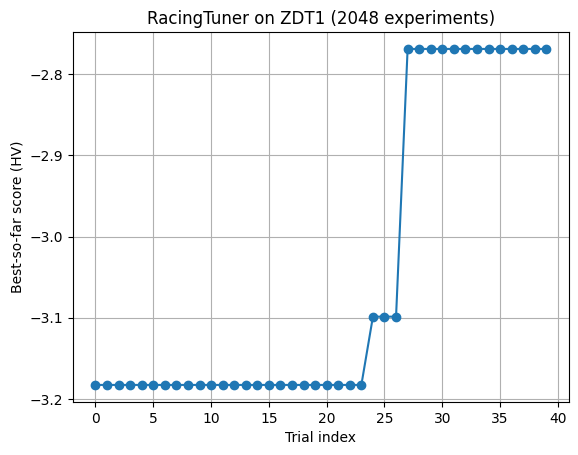

In [7]:
result = experiment.run(eval_fn, verbose=True)

print("Best tuned configuration:")
for k, v in result.best_config.items():
    print(f"  {k}: {v}")

print("\nNumber of trials:", len(result.tuning_history))

scores = [t.score for t in result.tuning_history]
best_so_far = []
current_best = -1e9
for s in scores:
    current_best = max(current_best, s)
    best_so_far.append(current_best)

plt.figure()
plt.plot(range(len(best_so_far)), best_so_far, marker="o", linestyle="-")
plt.xlabel("Trial index")
plt.ylabel("Best-so-far score (HV)")
plt.title("RacingTuner on ZDT1 (2048 experiments)")
plt.grid(True)
plt.show()

In [8]:
# Top 3 configuraciones por score (mayor es mejor)
top3 = sorted(result.tuning_history, key=lambda t: t.score, reverse=True)[:3]

print("Top 3 del tuning:")
for i, t in enumerate(top3, 1):
    print(f"{i}) trial_id={t.trial_id}, score={t.score:.6f}")
    for k, v in t.config.items():
        print(f"   {k}: {v}")


Top 3 del tuning:
1) trial_id=27, score=-2.768727
   population_size: 107
   crossover_prob: 0.8737037455962365
   mutation_prob: 0.01
   sbx_eta: 40.0
   blend_alpha: 0.5605117045675839
   sigma_eta: 0.3690103979054032
   sigma_zeta: 0.020357811857822664
   sigma_xi: 0.3911080341245434
   epsilon: 0.413587068302073
   mutation_eta: 36.77441941642364
   perturbation: 0.6799640071058235
   gauss_sigma: 0.25909660161247716
   gamma: 0.29198537854627243
   uniform_perturb: 0.10455045228218608
   crossover_type: spx
   mutation_type: pm
   repair: resample
2) trial_id=24, score=-3.098689
   population_size: 139
   crossover_prob: 0.9375464121249053
   mutation_prob: 0.01
   sbx_eta: 34.952060774437506
   blend_alpha: 0.4808162780700872
   sigma_eta: 0.32090248773086205
   sigma_zeta: 0.10982609252784226
   sigma_xi: 0.49814530171214033
   epsilon: 0.6077422730584962
   mutation_eta: 35.05531940637672
   perturbation: 0.4569250373563197
   gauss_sigma: 0.22804846274371351
   gamma: 0.149647

## Notes and extensions

- This toy runner is intentionally lightweight; a full NSGA-II/III implementation would give stronger hypervolume.
- Try changing `max_experiments` (e.g., 512, 1024, 4096) to see scaling effects.
- Swap `ModelBasedSampler` for `UniformSampler` to compare sampling strategies.
- Extend to other problems (ZDT2, ZDT3, DTLZ1/2) by replacing the objective helpers and instances.